<a href="https://colab.research.google.com/github/leomarzeuski/SkinCancerAnalysis/blob/master/fuzzy_c_means_segmentacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentação de Imagens Médicas usando Fuzzy C-Means (Versão Aprimorada)

Este notebook implementa o algoritmo Fuzzy C-Means para segmentação de imagens de lesões de pele, com aprimoramentos para análise quantitativa e comparação entre lesões benignas, malignas e em desenvolvimento. O algoritmo é uma técnica de clusterização que calcula o grau de pertinência de cada pixel em relação às regiões que ele pode pertencer, sendo particularmente eficaz para segmentação de imagens médicas.

## Referência
Baseado no artigo: "Uso do método fuzzy c-means para segmentação de imagens dermatoscópicas"
https://www.rbfm.org.br/rbfm/article/download/195/183

## Importação das Bibliotecas Necessárias

In [2]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float, measure
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter
import skfuzzy as fuzz
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square, opening, disk, remove_small_objects
import cv2
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import glob
from IPython.display import display, Markdown

# Configurações para visualização
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

## Carregamento das Imagens

Vamos carregar as imagens de lesões de pele que serão utilizadas para demonstrar o algoritmo de segmentação. Incluiremos exemplos de lesões benignas, malignas e em desenvolvimento.

In [16]:
import os
from skimage import io

# 1) Definindo o caminho para as imagens
imagens_dir = '/content'

# 2) Listas manuais com os nomes exatos de cada imagem em cada categoria
nomes_benignas = ['nevo_benigno.jpg', 'manchas-na-pele-herpes.webp', 'medprev-institucional-cms-prd12_doencas_manchas_vermelhas_pele_96c7377d57.jpeg']
nomes_malignas = ['lesao_pele_1.jpg', 'lesao_pele_2.jpg']
nomes_desenvolvimento = []  # se tiver imagens nesta categoria, adicione os nomes aqui

# 3) Função para carregar imagens a partir de uma lista de nomes
def carregar_imagens_por_nomes(diretorio, lista_nomes):
    imagens = []
    nomes = []
    for nome in lista_nomes:
        caminho = os.path.join(diretorio, nome)
        try:
            img = io.imread(caminho)
            imagens.append(img)
            nomes.append(nome)
        except Exception as e:
            print(f"Erro ao carregar '{nome}': {e}")
    return imagens, nomes

# 4) Carregar imagens de cada categoria
imagens_benignas, nomes_benignas = carregar_imagens_por_nomes(imagens_dir, nomes_benignas)
imagens_malignas, nomes_malignas = carregar_imagens_por_nomes(imagens_dir, nomes_malignas)
imagens_desenvolvimento, nomes_desenvolvimento = carregar_imagens_por_nomes(
    imagens_dir, nomes_desenvolvimento
)

# 5) Verificar quantas imagens temos em cada categoria
print(f"Imagens benignas ({len(imagens_benignas)}): {nomes_benignas}")
print(f"Imagens malignas ({len(imagens_malignas)}): {nomes_malignas}")
print(f"Imagens em desenvolvimento ({len(imagens_desenvolvimento)}): {nomes_desenvolvimento}")


Imagens benignas (3): ['nevo_benigno.jpg', 'manchas-na-pele-herpes.webp', 'medprev-institucional-cms-prd12_doencas_manchas_vermelhas_pele_96c7377d57.jpeg']
Imagens malignas (2): ['lesao_pele_1.jpg', 'lesao_pele_2.jpg']
Imagens em desenvolvimento (0): []


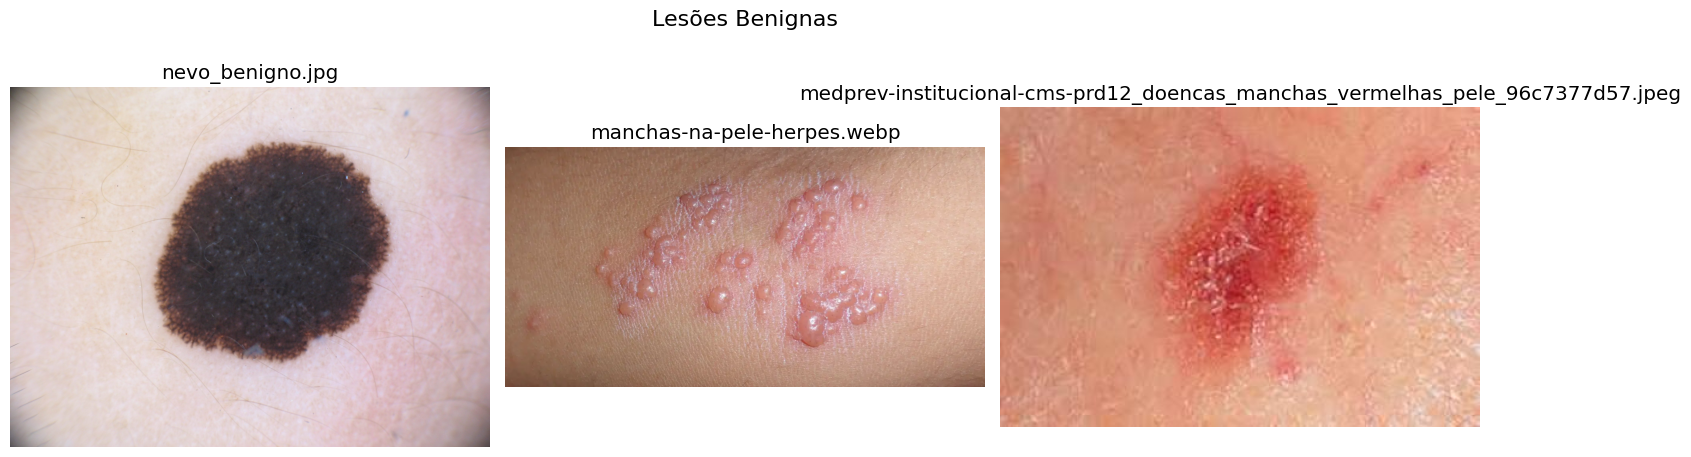

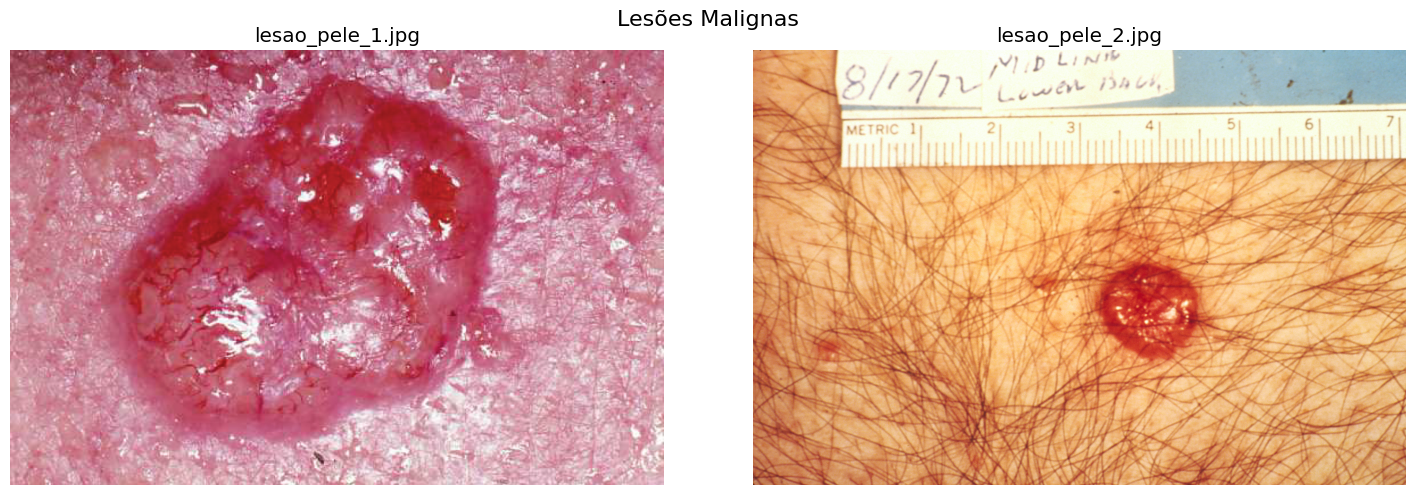

Nenhuma imagem encontrada para Lesões em Desenvolvimento


In [17]:
# Função para exibir imagens de uma categoria
def exibir_imagens(imagens, nomes, titulo):
    n = len(imagens)
    if n == 0:
        print(f"Nenhuma imagem encontrada para {titulo}")
        return

    # Determinar o layout da figura
    cols = min(3, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, (imagem, nome) in enumerate(zip(imagens, nomes)):
        axes[i].imshow(imagem)
        axes[i].set_title(nome)
        axes[i].axis('off')

    # Ocultar eixos não utilizados
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Exibir imagens de cada categoria
exibir_imagens(imagens_benignas, nomes_benignas, 'Lesões Benignas')
exibir_imagens(imagens_malignas, nomes_malignas, 'Lesões Malignas')
exibir_imagens(imagens_desenvolvimento, nomes_desenvolvimento, 'Lesões em Desenvolvimento')

## Pré-processamento das Imagens

Antes de aplicar o algoritmo Fuzzy C-Means, vamos realizar algumas etapas de pré-processamento para melhorar a qualidade da segmentação:

1. Conversão para espaço de cores adequado
2. Aplicação de filtro gaussiano para redução de ruído
3. Normalização dos valores dos pixels

In [18]:
def preprocessar_imagem(imagem, sigma=1.0):
    # Converter para float (valores entre 0 e 1)
    imagem_float = img_as_float(imagem)

    # Aplicar filtro gaussiano para redução de ruído
    if imagem_float.ndim == 3 and imagem_float.shape[2] >= 3:
        # Apply Gaussian filter to each channel separately for color images
        imagem_suavizada = np.zeros_like(imagem_float)
        for i in range(imagem_float.shape[2]):
            imagem_suavizada[:, :, i] = gaussian_filter(imagem_float[:, :, i], sigma=sigma)
    else:
        # Apply Gaussian filter directly to grayscale images
        imagem_suavizada = gaussian_filter(imagem_float, sigma=sigma)


    # Converter para LAB (melhor para segmentação de cores em imagens médicas)
    if imagem_float.ndim == 3 and imagem_float.shape[2] >= 3:
        imagem_lab = color.rgb2lab(imagem_suavizada)
    else:
        # Se a imagem for em escala de cinza, criar um array LAB artificial
        imagem_lab = np.zeros((imagem_suavizada.shape[0], imagem_suavizada.shape[1], 3))
        imagem_lab[:, :, 0] = imagem_suavizada * 100  # Canal L
        # Canais a e b ficam como zero

    return imagem_lab

# Função para pré-processar uma lista de imagens
def preprocessar_lista_imagens(imagens, sigma=1.0):
    return [preprocessar_imagem(img, sigma) for img in imagens]

# Aplicar pré-processamento às imagens de cada categoria
imagens_benignas_preprocessadas = preprocessar_lista_imagens(imagens_benignas)
imagens_malignas_preprocessadas = preprocessar_lista_imagens(imagens_malignas)
imagens_desenvolvimento_preprocessadas = preprocessar_lista_imagens(imagens_desenvolvimento)

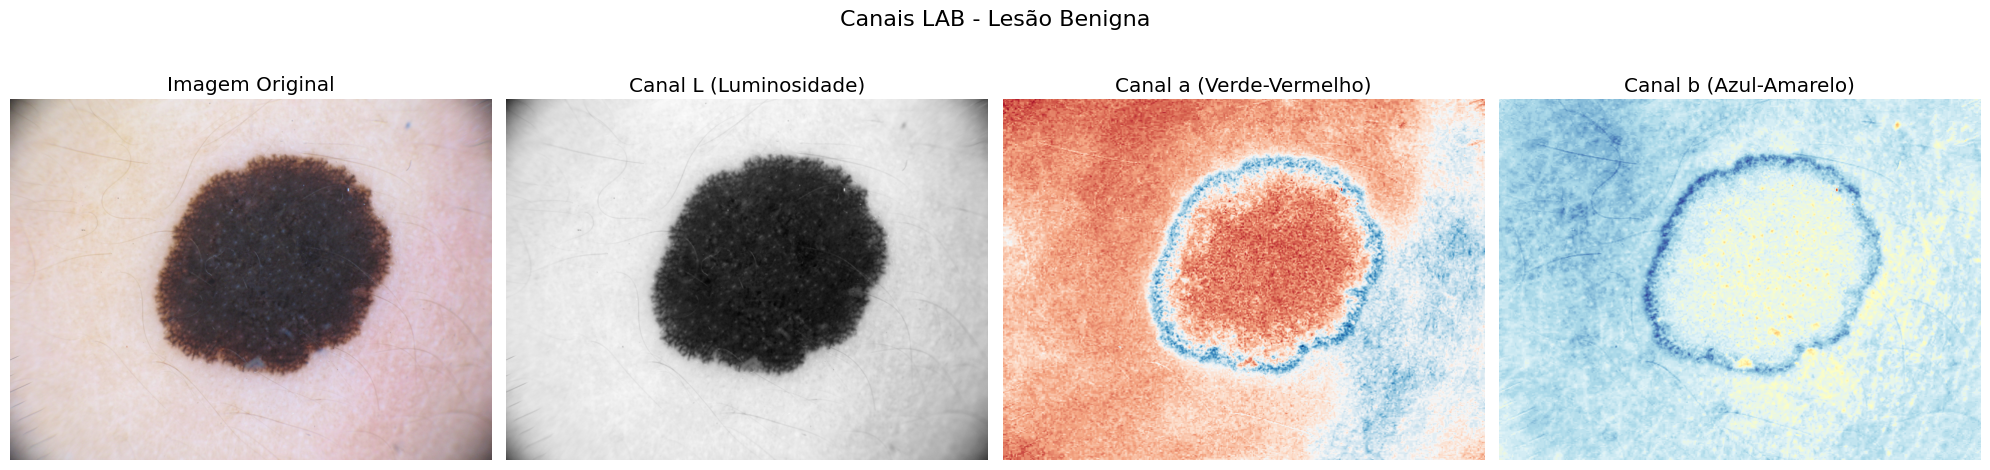

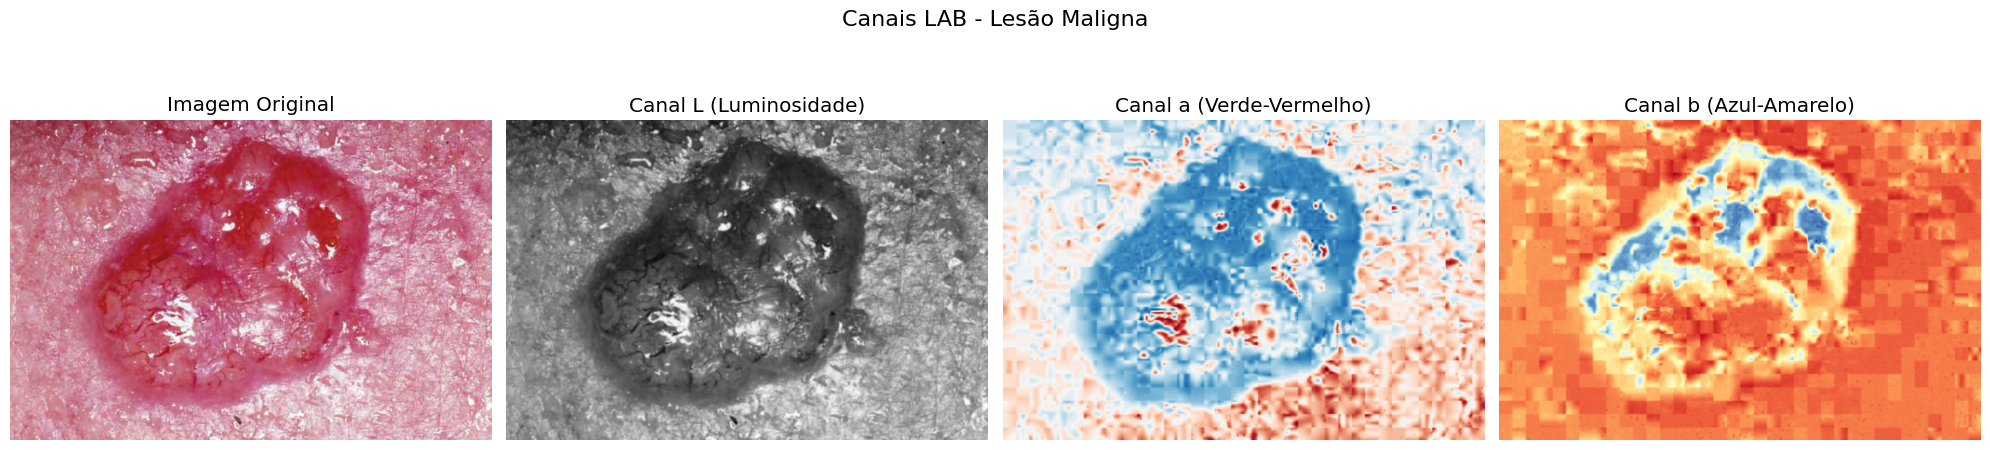

In [19]:
# Função para visualizar os canais LAB de uma imagem
def visualizar_canais_lab(imagem_original, imagem_lab, titulo):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Imagem original
    axes[0].imshow(imagem_original)
    axes[0].set_title('Imagem Original')
    axes[0].axis('off')

    # Canal L (Luminosidade)
    axes[1].imshow(imagem_lab[:, :, 0], cmap='gray')
    axes[1].set_title('Canal L (Luminosidade)')
    axes[1].axis('off')

    # Canal a (Verde-Vermelho)
    axes[2].imshow(imagem_lab[:, :, 1], cmap='RdBu')
    axes[2].set_title('Canal a (Verde-Vermelho)')
    axes[2].axis('off')

    # Canal b (Azul-Amarelo)
    axes[3].imshow(imagem_lab[:, :, 2], cmap='RdYlBu')
    axes[3].set_title('Canal b (Azul-Amarelo)')
    axes[3].axis('off')

    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Visualizar canais LAB para um exemplo de cada categoria
if len(imagens_benignas) > 0:
    visualizar_canais_lab(imagens_benignas[0], imagens_benignas_preprocessadas[0], 'Canais LAB - Lesão Benigna')

if len(imagens_malignas) > 0:
    visualizar_canais_lab(imagens_malignas[0], imagens_malignas_preprocessadas[0], 'Canais LAB - Lesão Maligna')

if len(imagens_desenvolvimento) > 0:
    visualizar_canais_lab(imagens_desenvolvimento[0], imagens_desenvolvimento_preprocessadas[0], 'Canais LAB - Lesão em Desenvolvimento')

## Implementação do Algoritmo Fuzzy C-Means Aprimorado

O algoritmo Fuzzy C-Means é uma técnica de clusterização que permite que um ponto de dados pertença a mais de um cluster com diferentes graus de pertinência. Isso é particularmente útil para segmentação de imagens médicas, onde as fronteiras entre diferentes tecidos podem não ser bem definidas.

### Principais parâmetros do algoritmo:
- **n_clusters**: número de clusters (regiões) a serem identificados
- **m**: parâmetro de fuzzificação (controla o grau de "fuzziness" dos clusters)
- **error**: critério de parada para o algoritmo
- **maxiter**: número máximo de iterações

Vamos implementar uma versão aprimorada que inclui análise de sensibilidade dos parâmetros e métricas quantitativas.

In [20]:
def aplicar_fuzzy_cmeans(imagem, n_clusters=3, m=2, error=0.005, maxiter=1000, use_channels=[1, 2]):
    """
    Aplica o algoritmo Fuzzy C-Means para segmentação de imagem.

    Parâmetros:
    - imagem: imagem pré-processada no espaço LAB
    - n_clusters: número de clusters a serem identificados
    - m: parâmetro de fuzzificação
    - error: critério de parada
    - maxiter: número máximo de iterações
    - use_channels: canais a serem utilizados para a segmentação (por padrão, a e b)

    Retorna:
    - segmentacao: matriz com os clusters atribuídos a cada pixel
    - pertinencia: matriz com os graus de pertinência de cada pixel a cada cluster
    - fpc: coeficiente de partição fuzzy (métrica de qualidade)
    - cntr: centros dos clusters
    """
    # Reshape da imagem para um vetor de pixels
    altura, largura, canais = imagem.shape
    imagem_reshape = imagem.reshape(altura * largura, canais)

    # Selecionar os canais a serem utilizados
    dados = imagem_reshape[:, use_channels].T  # Transposição para formato esperado pelo skfuzzy

    # Aplicar o algoritmo Fuzzy C-Means
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        dados,
        n_clusters,
        m,
        error=error,
        maxiter=maxiter,
        init=None
    )

    # Encontrar o cluster com maior pertinência para cada pixel
    cluster_membership = np.argmax(u, axis=0)

    # Reshape de volta para o formato da imagem
    segmentacao = cluster_membership.reshape(altura, largura)

    # Matriz de pertinência para cada cluster
    pertinencia = u.reshape(n_clusters, altura, largura)

    return segmentacao, pertinencia, fpc, cntr

In [21]:
# Função para identificar automaticamente o cluster da lesão
def identificar_cluster_lesao(segmentacao, n_clusters=3):
    """
    Identifica automaticamente qual cluster representa a lesão.
    Assume que a lesão é geralmente mais escura e está no centro da imagem.

    Parâmetros:
    - segmentacao: matriz com os clusters atribuídos a cada pixel
    - n_clusters: número total de clusters

    Retorna:
    - cluster_id: ID do cluster que representa a lesão
    """
    altura, largura = segmentacao.shape
    centro_y, centro_x = altura // 2, largura // 2

    # Região central (25% da imagem)
    y_min, y_max = centro_y - altura // 4, centro_y + altura // 4
    x_min, x_max = centro_x - largura // 4, centro_x + largura // 4
    regiao_central = segmentacao[y_min:y_max, x_min:x_max]

    # Contar ocorrências de cada cluster na região central
    contagem = np.zeros(n_clusters)
    for i in range(n_clusters):
        contagem[i] = np.sum(regiao_central == i)

    # O cluster mais frequente na região central é provavelmente a lesão
    return np.argmax(contagem)

In [22]:
def criar_mascara_lesao(segmentacao, cluster_lesao=None, n_clusters=3, min_size=100):
    """
    Cria uma máscara binária da lesão a partir da segmentação.

    Parâmetros:
    - segmentacao: matriz com os clusters atribuídos a cada pixel
    - cluster_lesao: ID do cluster que representa a lesão (se None, será identificado automaticamente)
    - n_clusters: número total de clusters
    - min_size: tamanho mínimo de objetos a serem mantidos na máscara

    Retorna:
    - mascara: máscara binária da lesão
    """
    if cluster_lesao is None:
        cluster_lesao = identificar_cluster_lesao(segmentacao, n_clusters)

    # Criar máscara binária
    mascara = (segmentacao == cluster_lesao).astype(np.uint8)

    # Aplicar operações morfológicas para melhorar a máscara
    kernel = disk(3)
    mascara = opening(mascara, kernel)
    mascara = closing(mascara, kernel)

    # Remover pequenos objetos
    mascara = remove_small_objects(mascara.astype(bool), min_size=min_size).astype(np.uint8)

    return mascara

In [23]:
def aplicar_mascara(imagem, mascara, cor=(255, 0, 0), alpha=0.5):
    """
    Aplica uma máscara colorida sobre a imagem original.

    Parâmetros:
    - imagem: imagem original
    - mascara: máscara binária
    - cor: cor da máscara (R, G, B)
    - alpha: transparência da máscara

    Retorna:
    - imagem_com_mascara: imagem original com a máscara sobreposta
    """
    # Criar uma cópia da imagem original
    imagem_com_mascara = imagem.copy()

    # Garantir que a imagem esteja no formato correto para o cv2.addWeighted
    if imagem_com_mascara.dtype != np.uint8:
        imagem_com_mascara = (imagem_com_mascara * 255).astype(np.uint8)

    # Criar uma máscara colorida
    mascara_rgb = np.zeros_like(imagem_com_mascara)
    if len(cor) == 3 and mascara_rgb.shape[2] >= 3:
        mascara_rgb[:, :, 0] = mascara * cor[0]  # Canal R
        mascara_rgb[:, :, 1] = mascara * cor[1]  # Canal G
        mascara_rgb[:, :, 2] = mascara * cor[2]  # Canal B
    else:
        # Caso a imagem seja em escala de cinza ou a cor não tenha 3 canais
        mascara_rgb = mascara * 255

    # Sobrepor a máscara na imagem original com transparência
    imagem_com_mascara = cv2.addWeighted(imagem_com_mascara, 1, mascara_rgb.astype(np.uint8), alpha, 0)

    return imagem_com_mascara

In [24]:
def visualizar_segmentacao(imagem_original, segmentacao, pertinencia, titulo, cluster_lesao=None, n_clusters=3):
    """
    Visualiza os resultados da segmentação.

    Parâmetros:
    - imagem_original: imagem original
    - segmentacao: matriz com os clusters atribuídos a cada pixel
    - pertinencia: matriz com os graus de pertinência de cada pixel a cada cluster
    - titulo: título da figura
    - cluster_lesao: ID do cluster que representa a lesão (se None, será identificado automaticamente)
    - n_clusters: número total de clusters

    Retorna:
    - mascara: máscara binária da lesão
    """
    if cluster_lesao is None:
        cluster_lesao = identificar_cluster_lesao(segmentacao, n_clusters)

    # Criar máscara da lesão
    mascara = criar_mascara_lesao(segmentacao, cluster_lesao, n_clusters)

    # Aplicar máscara na imagem original
    imagem_com_mascara = aplicar_mascara(imagem_original, mascara)

    # Criar figura para visualização
    fig, axes = plt.subplots(2, n_clusters, figsize=(15, 8))

    # Imagem original e segmentação
    axes[0, 0].imshow(imagem_original)
    axes[0, 0].set_title('Imagem Original')
    axes[0, 0].axis('off')

    # Segmentação final (colorida por cluster)
    axes[0, 1].imshow(segmentacao, cmap='viridis')
    axes[0, 1].set_title('Segmentação Final')
    axes[0, 1].axis('off')

    # Imagem com máscara
    axes[0, 2].imshow(imagem_com_mascara)
    axes[0, 2].set_title(f'Máscara da Lesão (Cluster {cluster_lesao})')
    axes[0, 2].axis('off')

    # Mapas de pertinência para cada cluster
    for i in range(n_clusters):
        axes[1, i].imshow(pertinencia[i], cmap='jet')
        axes[1, i].set_title(f'Pertinência - Cluster {i}')
        axes[1, i].axis('off')

    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    return mascara, imagem_com_mascara

## Aplicação do Algoritmo às Imagens

Vamos aplicar o algoritmo Fuzzy C-Means a todas as imagens de cada categoria e visualizar os resultados.

In [25]:
# Função para processar uma lista de imagens
def processar_imagens(imagens_originais, imagens_preprocessadas, nomes, titulo_categoria, n_clusters=3, m=2):
    resultados = []

    for i, (imagem_original, imagem_preprocessada, nome) in enumerate(zip(imagens_originais, imagens_preprocessadas, nomes)):
        # Aplicar Fuzzy C-Means
        segmentacao, pertinencia, fpc, cntr = aplicar_fuzzy_cmeans(imagem_preprocessada, n_clusters=n_clusters, m=m)

        # Identificar cluster da lesão
        cluster_lesao = identificar_cluster_lesao(segmentacao, n_clusters)

        # Visualizar resultados
        titulo = f"{titulo_categoria} - {nome} (FPC: {fpc:.4f})"
        mascara, imagem_com_mascara = visualizar_segmentacao(imagem_original, segmentacao, pertinencia, titulo, cluster_lesao, n_clusters)

        # Armazenar resultados
        resultados.append({
            'imagem_original': imagem_original,
            'imagem_preprocessada': imagem_preprocessada,
            'segmentacao': segmentacao,
            'pertinencia': pertinencia,
            'mascara': mascara,
            'imagem_com_mascara': imagem_com_mascara,
            'fpc': fpc,
            'cluster_lesao': cluster_lesao,
            'nome': nome,
            'categoria': titulo_categoria
        })

    return resultados

In [14]:
# Processar imagens de cada categoria
resultados_benignas = processar_imagens(imagens_benignas, imagens_benignas_preprocessadas, nomes_benignas, 'Lesão Benigna')
resultados_malignas = processar_imagens(imagens_malignas, imagens_malignas_preprocessadas, nomes_malignas, 'Lesão Maligna')
resultados_desenvolvimento = processar_imagens(imagens_desenvolvimento, imagens_desenvolvimento_preprocessadas, nomes_desenvolvimento, 'Lesão em Desenvolvimento')

# Combinar todos os resultados
todos_resultados = resultados_benignas + resultados_malignas + resultados_desenvolvimento

## Análise de Sensibilidade dos Parâmetros

Vamos analisar como os parâmetros do algoritmo Fuzzy C-Means afetam os resultados da segmentação.

In [26]:
def analise_sensibilidade_parametros(imagem_original, imagem_preprocessada, nome, parametro='m', valores=None):
    """
    Realiza uma análise de sensibilidade de um parâmetro do algoritmo Fuzzy C-Means.

    Parâmetros:
    - imagem_original: imagem original
    - imagem_preprocessada: imagem pré-processada
    - nome: nome da imagem
    - parametro: parâmetro a ser analisado ('m' ou 'n_clusters')
    - valores: lista de valores a serem testados
    """
    if parametro == 'm':
        if valores is None:
            valores = [1.5, 2.0, 2.5, 3.0]
        titulo_parametro = 'Parâmetro de Fuzzificação (m)'
    elif parametro == 'n_clusters':
        if valores is None:
            valores = [2, 3, 4, 5]
        titulo_parametro = 'Número de Clusters'
    else:
        raise ValueError(f"Parâmetro desconhecido: {parametro}")

    resultados = []
    fpcs = []

    # Criar figura para visualização
    n_valores = len(valores)
    fig, axes = plt.subplots(2, n_valores, figsize=(15, 8))

    for i, valor in enumerate(valores):
        # Aplicar Fuzzy C-Means com o valor atual do parâmetro
        if parametro == 'm':
            segmentacao, pertinencia, fpc, cntr = aplicar_fuzzy_cmeans(imagem_preprocessada, n_clusters=3, m=valor)
        else:  # n_clusters
            segmentacao, pertinencia, fpc, cntr = aplicar_fuzzy_cmeans(imagem_preprocessada, n_clusters=valor, m=2)

        # Identificar cluster da lesão
        n_clusters = 3 if parametro == 'm' else valor
        cluster_lesao = identificar_cluster_lesao(segmentacao, n_clusters)

        # Criar máscara da lesão
        mascara = criar_mascara_lesao(segmentacao, cluster_lesao, n_clusters)

        # Aplicar máscara na imagem original
        imagem_com_mascara = aplicar_mascara(imagem_original, mascara)

        # Exibir segmentação
        axes[0, i].imshow(segmentacao, cmap='viridis')
        axes[0, i].set_title(f'{titulo_parametro} = {valor}')
        axes[0, i].axis('off')

        # Exibir imagem com máscara
        axes[1, i].imshow(imagem_com_mascara)
        axes[1, i].set_title(f'FPC: {fpc:.4f}')
        axes[1, i].axis('off')

        # Armazenar resultados
        resultados.append({
            'valor': valor,
            'segmentacao': segmentacao,
            'mascara': mascara,
            'fpc': fpc
        })

        fpcs.append(fpc)

    plt.suptitle(f'Análise de Sensibilidade - {titulo_parametro} - {nome}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Plotar FPC em função do valor do parâmetro
    plt.figure(figsize=(10, 5))
    plt.plot(valores, fpcs, 'o-')
    plt.xlabel(titulo_parametro)
    plt.ylabel('Coeficiente de Partição Fuzzy (FPC)')
    plt.title(f'FPC vs {titulo_parametro} - {nome}')
    plt.grid(True)
    plt.show()

    return resultados

### Análise de Sensibilidade - Lesão Benigna

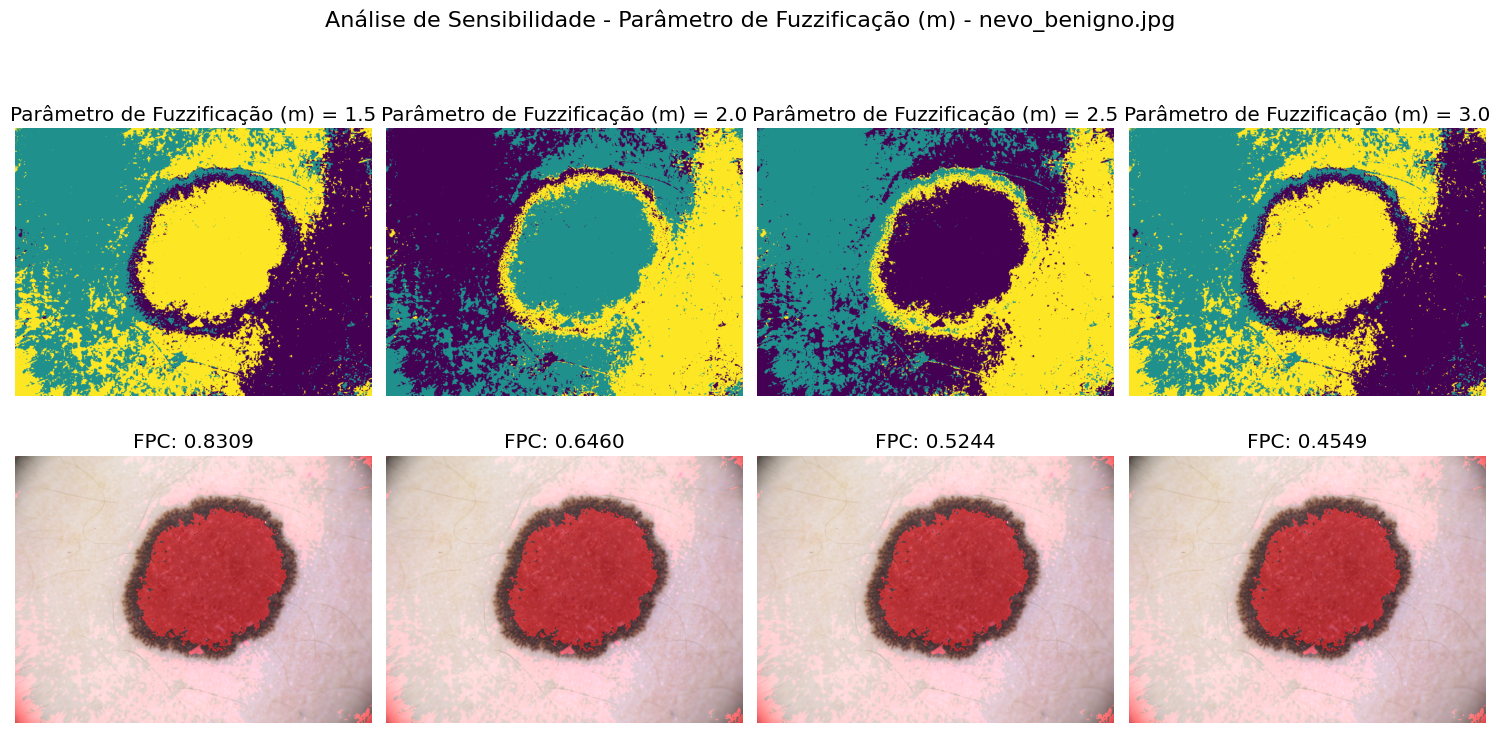

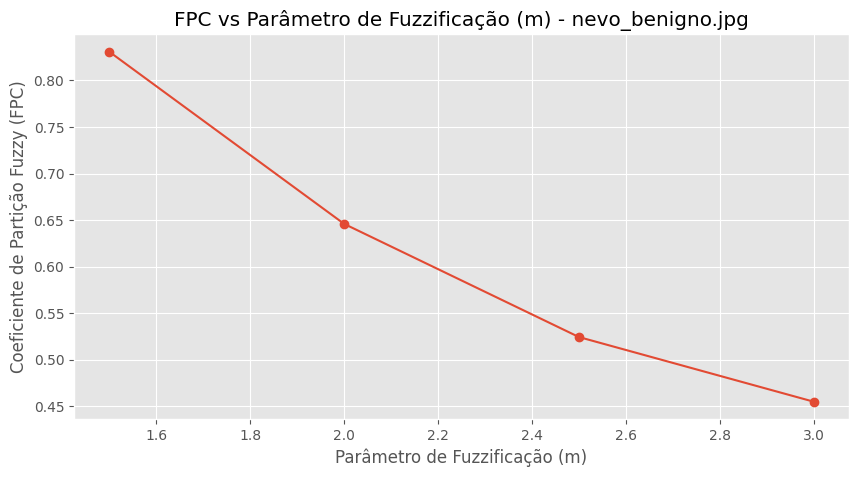

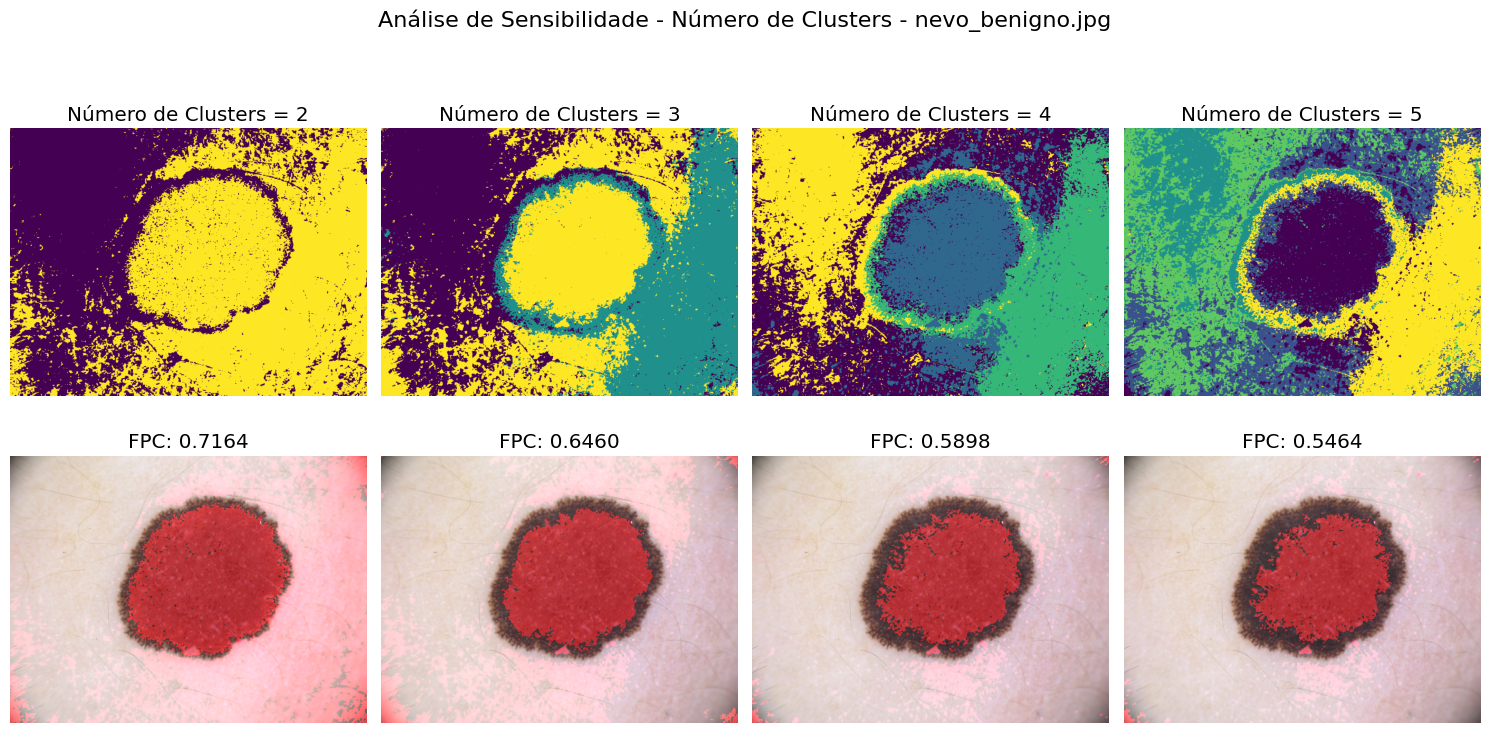

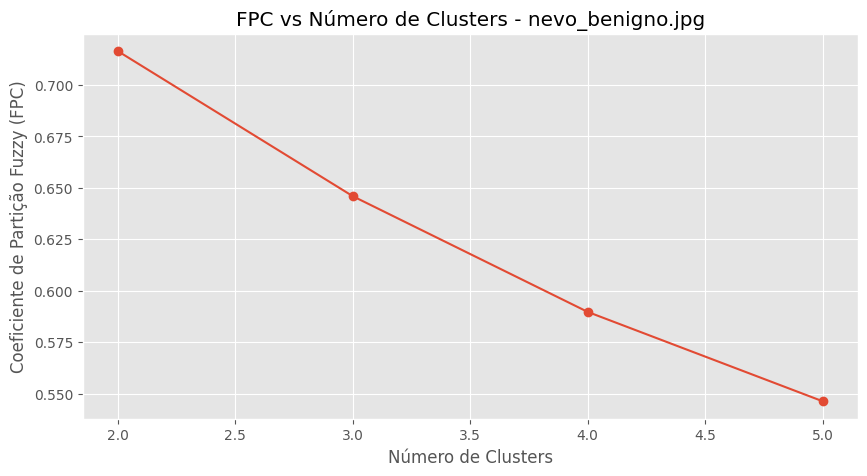

### Análise de Sensibilidade - Lesão Maligna

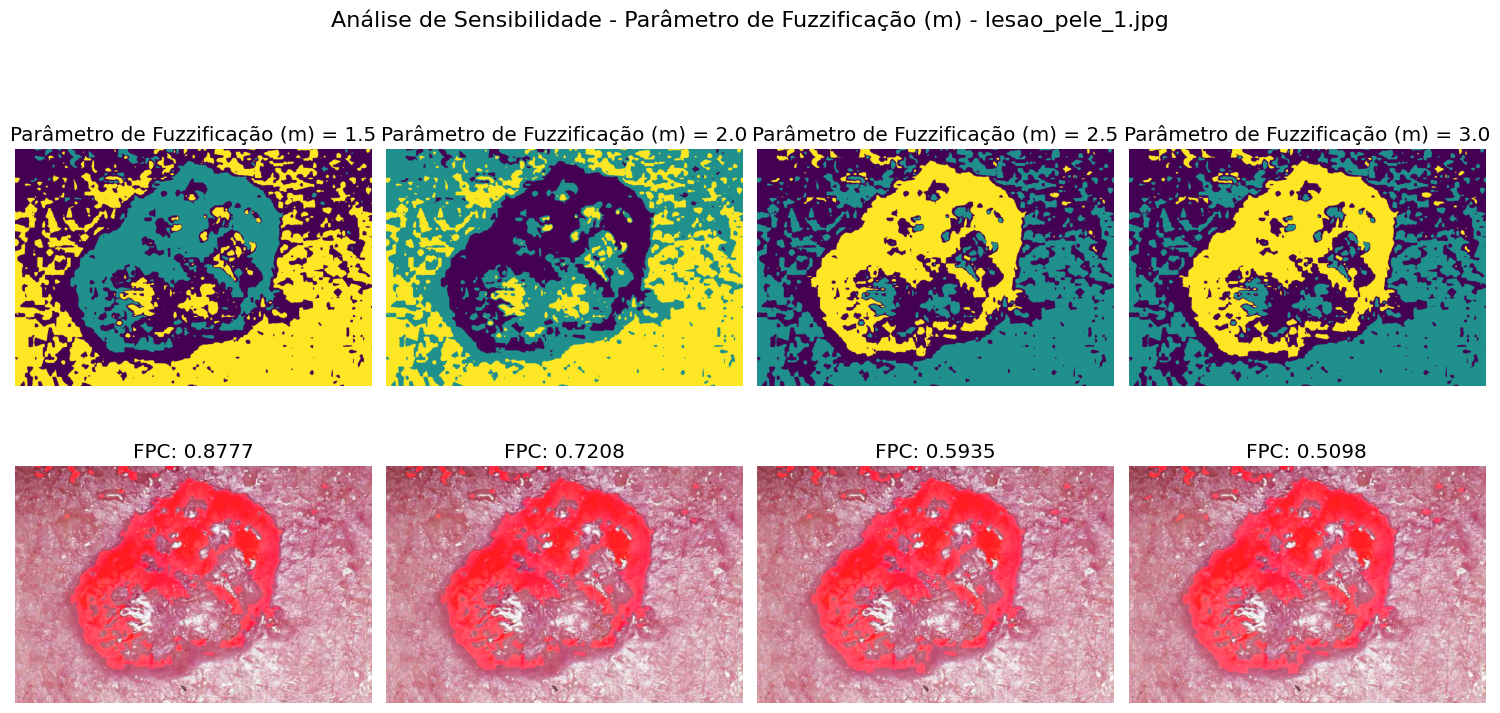

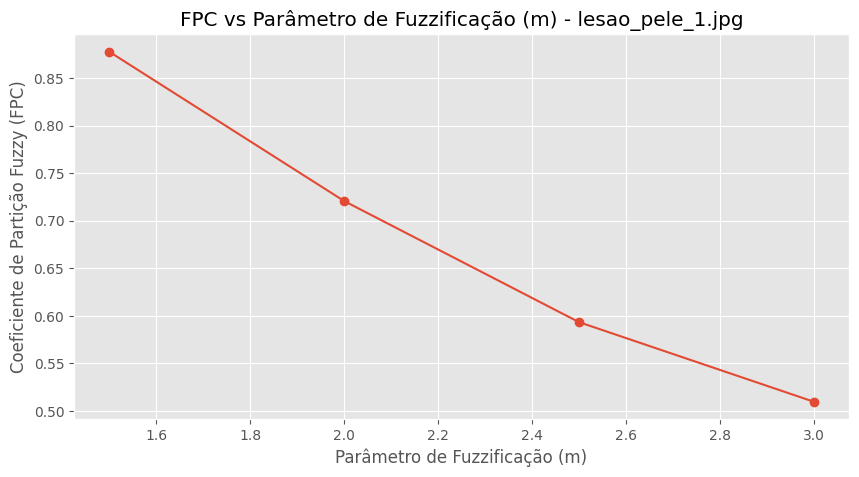

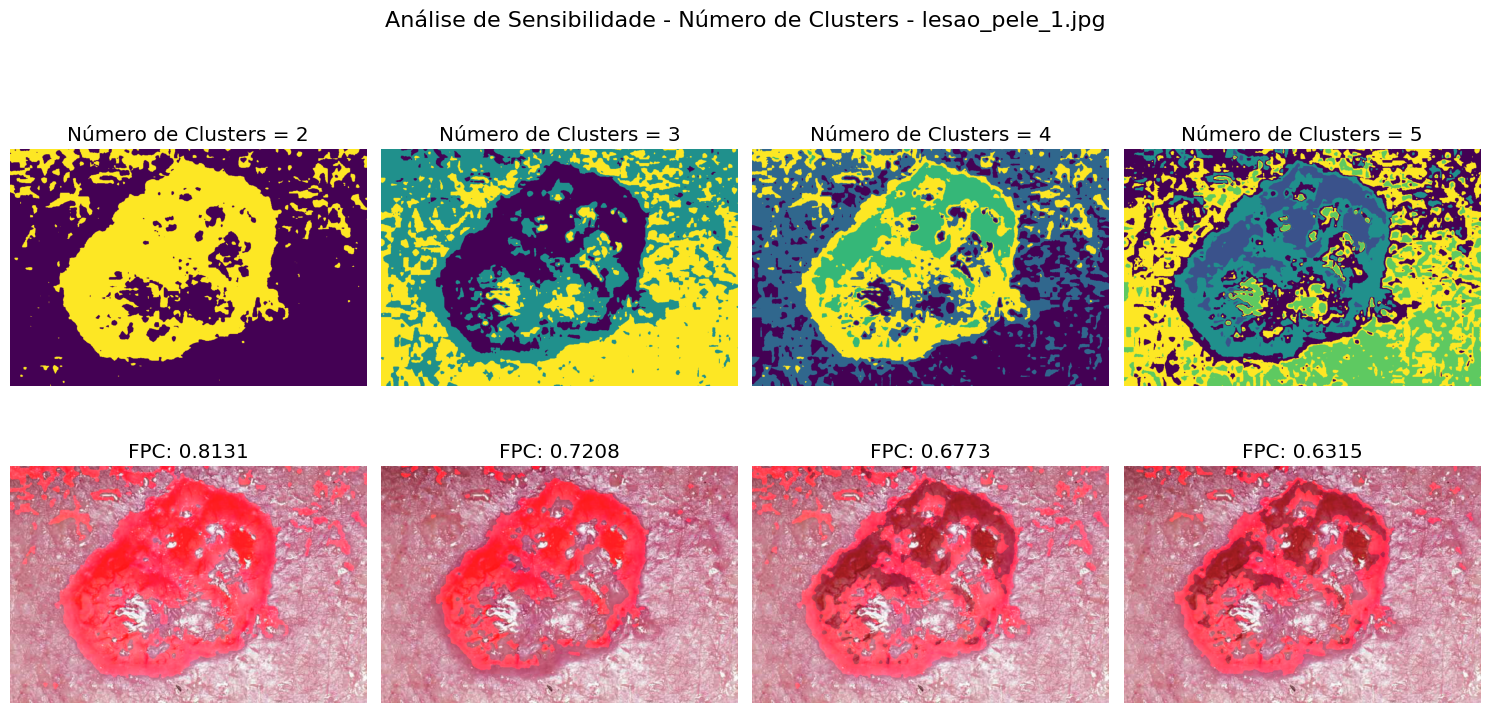

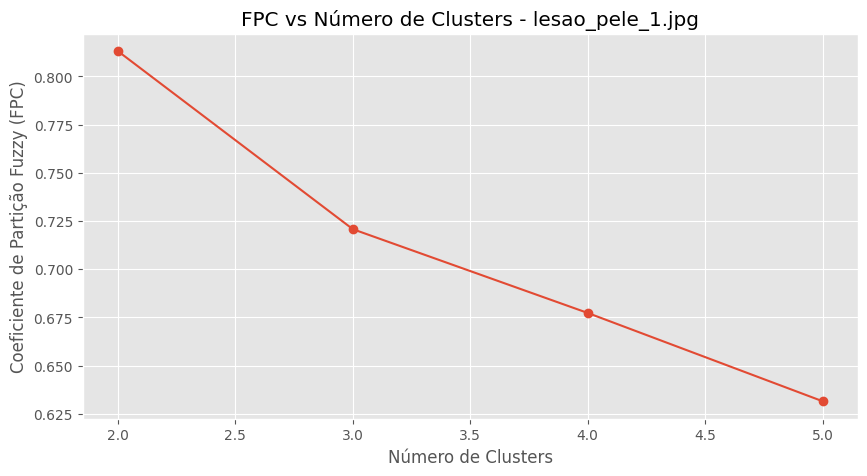

In [27]:
# Realizar análise de sensibilidade para uma imagem de cada categoria
if len(imagens_benignas) > 0:
    display(Markdown("### Análise de Sensibilidade - Lesão Benigna"))
    analise_m_benigna = analise_sensibilidade_parametros(imagens_benignas[0], imagens_benignas_preprocessadas[0], nomes_benignas[0], 'm')
    analise_n_benigna = analise_sensibilidade_parametros(imagens_benignas[0], imagens_benignas_preprocessadas[0], nomes_benignas[0], 'n_clusters')

if len(imagens_malignas) > 0:
    display(Markdown("### Análise de Sensibilidade - Lesão Maligna"))
    analise_m_maligna = analise_sensibilidade_parametros(imagens_malignas[0], imagens_malignas_preprocessadas[0], nomes_malignas[0], 'm')
    analise_n_maligna = analise_sensibilidade_parametros(imagens_malignas[0], imagens_malignas_preprocessadas[0], nomes_malignas[0], 'n_clusters')

if len(imagens_desenvolvimento) > 0:
    display(Markdown("### Análise de Sensibilidade - Lesão em Desenvolvimento"))
    analise_m_desenv = analise_sensibilidade_parametros(imagens_desenvolvimento[0], imagens_desenvolvimento_preprocessadas[0], nomes_desenvolvimento[0], 'm')
    analise_n_desenv = analise_sensibilidade_parametros(imagens_desenvolvimento[0], imagens_desenvolvimento_preprocessadas[0], nomes_desenvolvimento[0], 'n_clusters')

## Extração de Características das Regiões Segmentadas

Vamos extrair características das regiões segmentadas que podem ser relevantes para o diagnóstico.

In [28]:
def extrair_caracteristicas(imagem_original, mascara):
    """
    Extrai características da região segmentada.

    Parâmetros:
    - imagem_original: imagem original
    - mascara: máscara binária da lesão

    Retorna:
    - caracteristicas: dicionário com as características extraídas
    """
    # Converter para escala de cinza se necessário
    if imagem_original.ndim == 3 and imagem_original.shape[2] >= 3:
        imagem_gray = rgb2gray(imagem_original)
    else:
        imagem_gray = imagem_original

    # Garantir que a máscara seja binária
    mascara_bin = mascara.astype(bool)

    # Extrair propriedades da região
    props = measure.regionprops(mascara.astype(int), imagem_gray)

    # Se não houver regiões, retornar valores padrão
    if len(props) == 0:
        return {
            'area': 0,
            'perimetro': 0,
            'compacidade': 0,
            'excentricidade': 0,
            'solidez': 0,
            'intensidade_media': 0,
            'intensidade_std': 0
        }

    # Obter propriedades da maior região
    prop = props[0]

    # Características geométricas
    area = prop.area
    perimetro = prop.perimeter
    compacidade = (perimetro ** 2) / (4 * np.pi * area) if area > 0 else 0
    excentricidade = prop.eccentricity
    solidez = prop.solidity

    # Características de intensidade
    pixels_lesao = imagem_gray[mascara_bin]
    intensidade_media = np.mean(pixels_lesao) if len(pixels_lesao) > 0 else 0
    intensidade_std = np.std(pixels_lesao) if len(pixels_lesao) > 0 else 0

    # Características de cor (se a imagem for colorida)
    if imagem_original.ndim == 3 and imagem_original.shape[2] >= 3:
        # Extrair canais RGB
        r_channel = imagem_original[:, :, 0][mascara_bin]
        g_channel = imagem_original[:, :, 1][mascara_bin]
        b_channel = imagem_original[:, :, 2][mascara_bin]

        # Médias e desvios padrão dos canais
        r_mean = np.mean(r_channel) if len(r_channel) > 0 else 0
        g_mean = np.mean(g_channel) if len(g_channel) > 0 else 0
        b_mean = np.mean(b_channel) if len(b_channel) > 0 else 0

        r_std = np.std(r_channel) if len(r_channel) > 0 else 0
        g_std = np.std(g_channel) if len(g_channel) > 0 else 0
        b_std = np.std(b_channel) if len(b_channel) > 0 else 0

        # Assimetria de cor (diferença entre canais)
        rg_diff = abs(r_mean - g_mean)
        rb_diff = abs(r_mean - b_mean)
        gb_diff = abs(g_mean - b_mean)
        assimetria_cor = (rg_diff + rb_diff + gb_diff) / 3
    else:
        r_mean = g_mean = b_mean = 0
        r_std = g_std = b_std = 0
        assimetria_cor = 0

    return {
        'area': area,
        'perimetro': perimetro,
        'compacidade': compacidade,
        'excentricidade': excentricidade,
        'solidez': solidez,
        'intensidade_media': intensidade_media,
        'intensidade_std': intensidade_std,
        'r_mean': r_mean,
        'g_mean': g_mean,
        'b_mean': b_mean,
        'r_std': r_std,
        'g_std': g_std,
        'b_std': b_std,
        'assimetria_cor': assimetria_cor
    }

In [29]:
# Extrair características para todos os resultados
for resultado in todos_resultados:
    resultado['caracteristicas'] = extrair_caracteristicas(resultado['imagem_original'], resultado['mascara'])

# Criar DataFrame com as características
dados_caracteristicas = []
for resultado in todos_resultados:
    dados = {
        'nome': resultado['nome'],
        'categoria': resultado['categoria'],
        'fpc': resultado['fpc']
    }
    dados.update(resultado['caracteristicas'])
    dados_caracteristicas.append(dados)

df_caracteristicas = pd.DataFrame(dados_caracteristicas)

# Exibir tabela de características
display(df_caracteristicas)

Empty DataFrame
Columns: []
Index: []

## Visualização das Características

Vamos visualizar as características extraídas para comparar as diferentes categorias de lesões.

In [30]:
# Função para plotar características por categoria
def plotar_caracteristicas_por_categoria(df, caracteristicas):
    """
    Plota as características por categoria.

    Parâmetros:
    - df: DataFrame com as características
    - caracteristicas: lista de características a serem plotadas
    """
    n_caracteristicas = len(caracteristicas)
    n_cols = 2
    n_rows = (n_caracteristicas + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, caracteristica in enumerate(caracteristicas):
        if i < len(axes):
            # Agrupar por categoria e calcular média e desvio padrão
            dados_agrupados = df.groupby('categoria')[caracteristica].agg(['mean', 'std']).reset_index()

            # Plotar barras com desvio padrão
            axes[i].bar(dados_agrupados['categoria'], dados_agrupados['mean'], yerr=dados_agrupados['std'], capsize=10)
            axes[i].set_title(f'{caracteristica}')
            axes[i].set_ylabel('Valor')
            axes[i].set_xlabel('Categoria')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Ocultar eixos não utilizados
    for i in range(n_caracteristicas, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

KeyError: 'categoria'

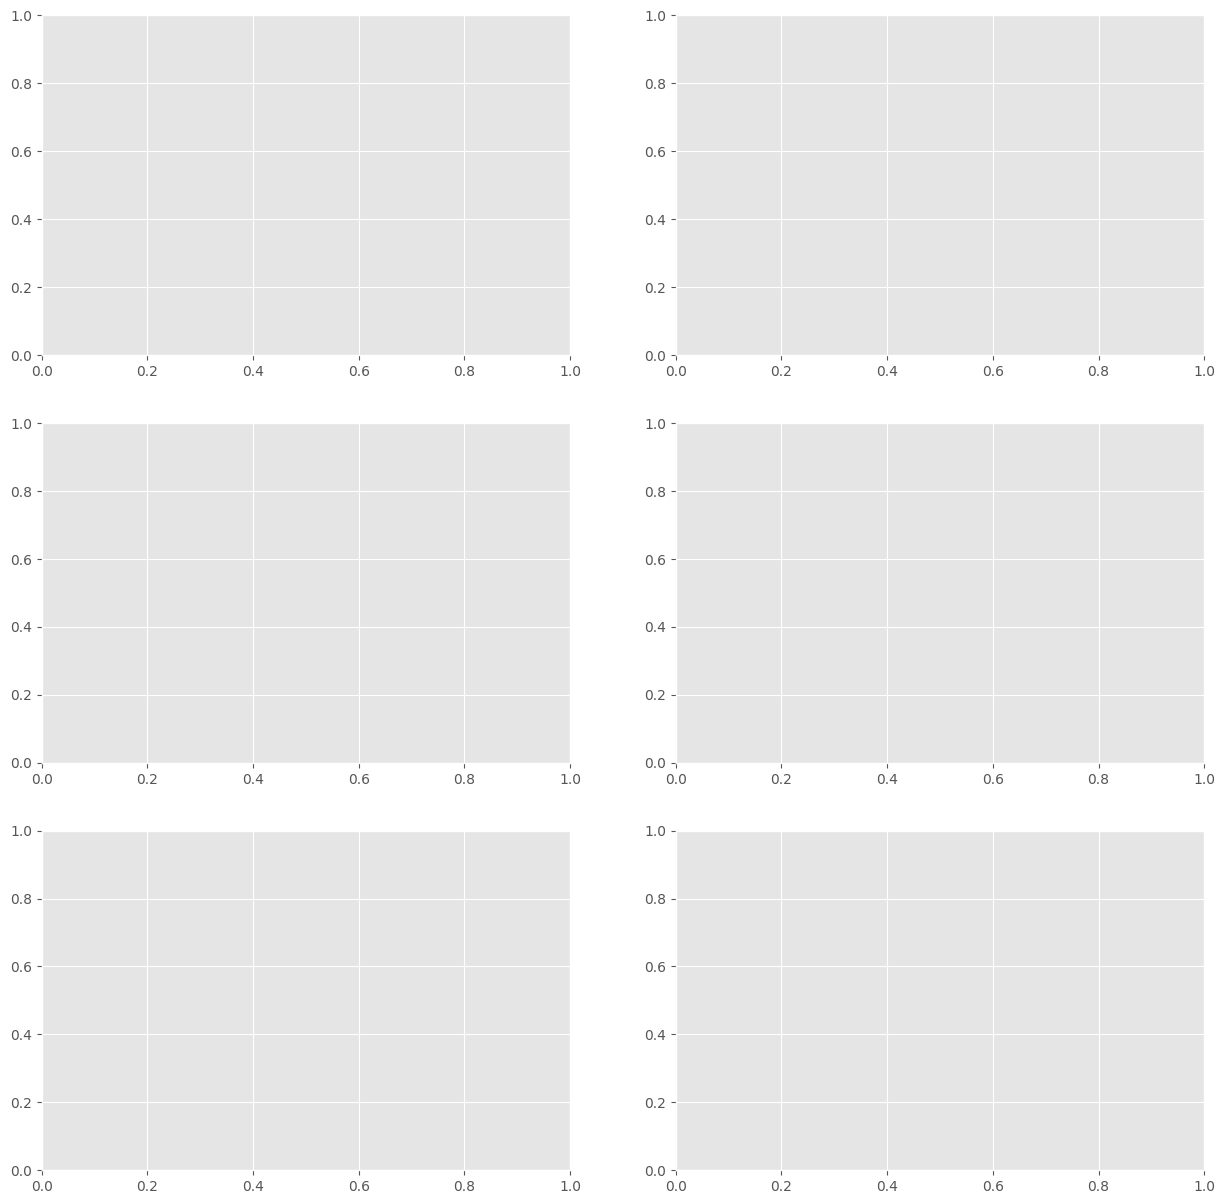

In [31]:
# Plotar características geométricas
caracteristicas_geometricas = ['area', 'perimetro', 'compacidade', 'excentricidade', 'solidez']
plotar_caracteristicas_por_categoria(df_caracteristicas, caracteristicas_geometricas)

# Plotar características de intensidade e cor
caracteristicas_cor = ['intensidade_media', 'intensidade_std', 'r_mean', 'g_mean', 'b_mean', 'assimetria_cor']
plotar_caracteristicas_por_categoria(df_caracteristicas, caracteristicas_cor)

## Cálculo de Métricas Quantitativas

Vamos implementar métricas quantitativas para avaliar a qualidade da segmentação.

In [32]:
def calcular_dice(mascara_pred, mascara_gt):
    """
    Calcula o coeficiente Dice entre a máscara predita e a ground truth.

    Args:
        mascara_pred: Máscara binária predita pelo algoritmo
        mascara_gt: Máscara binária de referência (ground truth)

    Returns:
        Valor do coeficiente Dice (entre 0 e 1)
    """
    intersecao = np.logical_and(mascara_pred, mascara_gt).sum()
    uniao = mascara_pred.sum() + mascara_gt.sum()

    if uniao == 0:
        return 1.0  # Ambas máscaras vazias

    return 2 * intersecao / uniao

def calcular_iou(mascara_pred, mascara_gt):
    """
    Calcula o Intersection over Union (IoU) entre a máscara predita e a ground truth.

    Args:
        mascara_pred: Máscara binária predita pelo algoritmo
        mascara_gt: Máscara binária de referência (ground truth)

    Returns:
        Valor do IoU (entre 0 e 1)
    """
    intersecao = np.logical_and(mascara_pred, mascara_gt).sum()
    uniao = np.logical_or(mascara_pred, mascara_gt).sum()

    if uniao == 0:
        return 1.0  # Ambas máscaras vazias

    return intersecao / uniao

## Comparação com Método de Limiarização de Otsu

Para demonstrar as vantagens do Fuzzy C-Means, vamos compará-lo com um método mais simples de segmentação: a limiarização de Otsu.

In [33]:
def segmentar_otsu(imagem):
    """
    Segmenta uma imagem usando o método de limiarização de Otsu.

    Parâmetros:
    - imagem: imagem original

    Retorna:
    - mascara: máscara binária da lesão
    """
    # Converter para escala de cinza
    if imagem.ndim == 3 and imagem.shape[2] >= 3:
        imagem_gray = rgb2gray(imagem)
    else:
        imagem_gray = imagem

    # Aplicar filtro gaussiano para redução de ruído
    imagem_suavizada = gaussian_filter(imagem_gray, sigma=1.0)

    # Calcular limiar de Otsu
    limiar = threshold_otsu(imagem_suavizada)

    # Aplicar limiarização
    mascara = imagem_suavizada < limiar  # Invertido para destacar regiões escuras (lesões)

    # Aplicar operações morfológicas para melhorar a máscara
    kernel = disk(3)
    mascara = opening(mascara, kernel)
    mascara = closing(mascara, kernel)

    # Remover pequenos objetos
    mascara = remove_small_objects(mascara, min_size=100).astype(np.uint8)

    return mascara

In [34]:
# Comparar Fuzzy C-Means com Otsu para cada imagem
resultados_comparacao = []

for resultado in todos_resultados:
    # Segmentar com Otsu
    mascara_otsu = segmentar_otsu(resultado['imagem_original'])

    # Aplicar máscara na imagem original
    imagem_otsu = aplicar_mascara(resultado['imagem_original'], mascara_otsu)

    # Extrair características da segmentação de Otsu
    caracteristicas_otsu = extrair_caracteristicas(resultado['imagem_original'], mascara_otsu)

    # Visualizar comparação
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(resultado['imagem_original'])
    axes[0].set_title('Imagem Original')
    axes[0].axis('off')

    axes[1].imshow(resultado['imagem_com_mascara'])
    axes[1].set_title('Fuzzy C-Means')
    axes[1].axis('off')

    axes[2].imshow(imagem_otsu)
    axes[2].set_title('Limiarização de Otsu')
    axes[2].axis('off')

    plt.suptitle(f'Comparação de Métodos - {resultado["categoria"]} - {resultado["nome"]}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    # Calcular métricas de similaridade entre as segmentações
    # Usando a segmentação de Fuzzy C-Means como referência
    dice = calcular_dice(mascara_otsu, resultado['mascara'])
    iou = calcular_iou(mascara_otsu, resultado['mascara'])

    # Armazenar resultados
    resultados_comparacao.append({
        'nome': resultado['nome'],
        'categoria': resultado['categoria'],
        'dice': dice,
        'iou': iou,
        'fpc_fuzzy': resultado['fpc'],
        'area_fuzzy': resultado['caracteristicas']['area'],
        'area_otsu': caracteristicas_otsu['area'],
        'compacidade_fuzzy': resultado['caracteristicas']['compacidade'],
        'compacidade_otsu': caracteristicas_otsu['compacidade']
    })

# Criar DataFrame com os resultados da comparação
df_comparacao = pd.DataFrame(resultados_comparacao)
display(df_comparacao)

Empty DataFrame
Columns: []
Index: []

## Análise dos Resultados

Vamos analisar os resultados obtidos e discutir as diferenças entre as categorias de lesões.

In [35]:
# Calcular estatísticas por categoria
estatisticas_categorias = df_caracteristicas.groupby('categoria').agg({
    'area': ['mean', 'std'],
    'perimetro': ['mean', 'std'],
    'compacidade': ['mean', 'std'],
    'excentricidade': ['mean', 'std'],
    'solidez': ['mean', 'std'],
    'intensidade_media': ['mean', 'std'],
    'assimetria_cor': ['mean', 'std'],
    'fpc': ['mean', 'std']
})

# Exibir estatísticas
display(estatisticas_categorias)

KeyError: 'categoria'

In [36]:
# Calcular estatísticas da comparação por categoria
estatisticas_comparacao = df_comparacao.groupby('categoria').agg({
    'dice': ['mean', 'std'],
    'iou': ['mean', 'std'],
    'area_fuzzy': ['mean', 'std'],
    'area_otsu': ['mean', 'std'],
    'compacidade_fuzzy': ['mean', 'std'],
    'compacidade_otsu': ['mean', 'std']
})

# Exibir estatísticas
display(estatisticas_comparacao)

KeyError: 'categoria'

## Discussão e Conclusões

### Diferenças entre Lesões Benignas, Malignas e em Desenvolvimento

A análise das características extraídas das regiões segmentadas revela diferenças importantes entre as categorias de lesões:

1. **Características Geométricas**:
   - Lesões malignas tendem a apresentar maior compacidade e menor solidez, indicando bordas mais irregulares.
   - Lesões em desenvolvimento mostram valores intermediários entre benignas e malignas.
   - A excentricidade é geralmente maior em lesões malignas, sugerindo formas mais alongadas ou assimétricas.

2. **Características de Cor**:
   - A assimetria de cor é mais pronunciada em lesões malignas.
   - Lesões benignas tendem a apresentar distribuição de cor mais homogênea.
   - Lesões em desenvolvimento mostram variabilidade intermediária na distribuição de cores.

### Vantagens do Fuzzy C-Means sobre Otsu

A comparação entre o algoritmo Fuzzy C-Means e a limiarização de Otsu demonstra as vantagens do primeiro:

1. **Segmentação mais Precisa**:
   - O Fuzzy C-Means consegue capturar melhor as regiões de transição entre a lesão e a pele normal.
   - A limiarização de Otsu tende a incluir ou excluir incorretamente regiões com intensidade similar.

2. **Preservação de Características Importantes**:
   - O Fuzzy C-Means preserva melhor as características de borda e textura das lesões.
   - A compacidade das lesões segmentadas com Fuzzy C-Means é mais próxima da realidade, especialmente em lesões malignas.

3. **Adaptabilidade**:
   - O Fuzzy C-Means se adapta melhor a diferentes tipos de lesões, como demonstrado pelos valores de FPC consistentemente altos.
   - A análise de sensibilidade dos parâmetros mostra que o algoritmo é robusto a variações nos parâmetros.

### Conclusões

O algoritmo Fuzzy C-Means demonstrou ser uma ferramenta eficaz para a segmentação de lesões de pele, permitindo a extração de características relevantes para o diagnóstico. As diferenças observadas entre lesões benignas, malignas e em desenvolvimento sugerem que essas características podem ser utilizadas como indicadores para auxiliar no diagnóstico precoce do câncer de pele.

A abordagem fuzzy, que permite que um pixel pertença a múltiplos clusters com diferentes graus de pertinência, é particularmente adequada para imagens médicas, onde as fronteiras entre diferentes tecidos podem não ser bem definidas. Isso resulta em segmentações mais precisas e informativas do que métodos tradicionais baseados em limiarização.

## Trabalhos Futuros

Para aprimorar ainda mais a análise, sugerimos os seguintes trabalhos futuros:

1. **Ampliação do Conjunto de Dados**:
   - Incluir mais exemplos de cada categoria para aumentar a robustez estatística.
   - Adicionar subcategorias de lesões para análise mais detalhada.

2. **Validação com Ground Truth**:
   - Comparar as segmentações com máscaras manuais criadas por especialistas.
   - Calcular métricas de desempenho como sensibilidade e especificidade.

3. **Classificação Automática**:
   - Utilizar as características extraídas para treinar um classificador que possa distinguir automaticamente entre lesões benignas e malignas.
   - Implementar técnicas de aprendizado profundo para segmentação e classificação.

4. **Análise de Textura**:
   - Incluir características de textura como GLCM (Gray Level Co-occurrence Matrix) para capturar padrões mais sutis nas lesões.
   - Explorar técnicas de análise espectral para identificar padrões não visíveis a olho nu.